In [ ]:
# Dataset donwload

!wget https://s3.amazonaws.com/ps.public.resources/ml-showcase/news_summary.csv
!wget https://s3.amazonaws.com/ps.public.resources/ml-showcase/news_summary_more.csv

#Importing Libraries

import pandas as pd
import spacy
from time import time
import re
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping





--2022-05-17 18:29:48--  https://s3.amazonaws.com/ps.public.resources/ml-showcase/news_summary.csv
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.163.192
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.163.192|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11896415 (11M) [text/csv]
Saving to: ‘news_summary.csv.2’

news_summary.csv.2  100%[===================>]  11.34M  38.4MB/s    in 0.3s    

2022-05-17 18:29:48 (38.4 MB/s) - ‘news_summary.csv.2’ saved [11896415/11896415]

--2022-05-17 18:29:49--  https://s3.amazonaws.com/ps.public.resources/ml-showcase/news_summary_more.csv
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.163.192
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.163.192|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 41399270 (39M) [text/csv]
Saving to: ‘news_summary_more.csv.2’

news_summary_more.c 100%[===================>]  39.48M  60.2MB/s    in 0.7s    

2022-05-17 18:29:49 (60.

In [ ]:
# Data Pre-Processing
# 
# We are combining data from the two csv files into a single DataFrame
# 
# To increase the intake of data points, we construct a new text column, utilizing one csv file
#
#
summary = pd.read_csv('news_summary.csv', encoding = "iso-8859-1")
raw = pd.read_csv('news_summary_more.csv', encoding = "iso-8859-1")

p_raw =  raw.iloc[:, 0:2].copy()
p_summary = summary.iloc[:, 0:6].copy()

p_summary['text'] = p_summary['author'].str.cat(p_summary['date'].str.cat(p_summary['read_more'].str.cat(p_summary['text'].str.cat(p_summary['ctext'], sep = " "), sep = " "),sep = " "), sep = " ")

p = pd.DataFrame()
p['text'] = pd.concat([p_raw['text'], p_summary['text']], ignore_index=True)
p['summary'] = pd.concat([p_raw['headlines'],p_summary['headlines']], ignore_index = True)

# Checking p.head(5) to show the data




In [ ]:
# 
# Data cleaning using python reglular expressions
#
# Remove _,-,~,+,. if it occurs more than one time consecutively, multiple spaces, single char between spaces, punctuations in the end
# Remove the characters - <>()|&©ø"',;?~*!
# Remove mailto:
# Remove \x9* in text (numbers)
# Replace INC nums to INC_NUM (incorporation numbers (TIN)), CM# CHG# to CM_NUM
# Replace any url to only the domain name


def data_clean(c):
  for r in c:
        
        r = re.sub("(\\t)", " ", str(r)).lower()
        r = re.sub("(\\r)", " ", str(r)).lower()
        r = re.sub("(\\n)", " ", str(r)).lower()
        r = re.sub("(__+)", " ", str(r)).lower()
        r = re.sub("(--+)", " ", str(r)).lower()
        r = re.sub("(~~+)", " ", str(r)).lower()
        r = re.sub("(\+\++)", " ", str(r)).lower()
        r = re.sub("(\.\.+)", " ", str(r)).lower()
        r = re.sub(r"[<>()|&©ø\[\]\'\",;?~*!]", " ", str(r)).lower()
        r = re.sub("(mailto:)", " ", str(r)).lower()
        r = re.sub(r"(\\x9\d)", " ", str(r)).lower()
        r = re.sub("([iI][nN][cC]\d+)", "INC_NUM", str(r)).lower()
        r = re.sub("([cC][mM]\d+)|([cC][hH][gG]\d+)", "CM_NUM", str(r)).lower()
        r = re.sub("(\.\s+)", " ", str(r)).lower()
        r = re.sub("(\-\s+)", " ", str(r)).lower()
        r = re.sub("(\:\s+)", " ", str(r)).lower()
        try:
            url = re.search(r"((https*:\/*)([^\/\s]+))(.[^\s]+)", str(r))
            repl_url = url.group(3)
            r = re.sub(r"((https*:\/*)([^\/\s]+))(.[^\s]+)", repl_url, str(r))
        except:
            pass
        r = re.sub("(\s+)", " ", str(r)).lower()
        r = re.sub("(\s+.\s+)", " ", str(r)).lower()
        yield r

text_processed = data_clean(p["text"])
summary_processed = data_clean(p["summary"])


**Using *spacy*** :
Loading the data with mehtod *pipe()* whcih ensures that all text & summaries are of *string* type

In [ ]:
process = spacy.load('en_core_web_sm', disable=['ner', 'parser']) 

text = [str(doc) for doc in process.pipe(text_processed, batch_size=5000)]

aummary = [ str(doc) for doc in process.pipe(summary_processed, batch_size=5000)]

tcmalloc: large alloc 1293983744 bytes == 0x891f4000 @  0x7f231760e001 0x7f2308fa91af 0x7f2308fffc23 0x7f2309000a87 0x7f23090a2823 0x593a92 0x593bc6 0x7f22f48cb1e3 0x59c097 0x7f22f48d3319 0x594b72 0x548cc1 0x51566f 0x593dd7 0x511e2c 0x4bc98a 0x532e76 0x594b72 0x515600 0x593dd7 0x511e2c 0x4bc98a 0x532e76 0x594b72 0x515600 0x549e0e 0x593fce 0x511e2c 0x4bc98a 0x532e76 0x594b72
tcmalloc: large alloc 1293983744 bytes == 0xd63fe000 @  0x7f231760e001 0x7f2308fa91af 0x7f2308fffc23 0x7f2309000a87 0x7f23090a2823 0x593a92 0x593bc6 0x7f22f48cb1e3 0x7f22f48ec28d 0x7f22f492e910 0x594b72 0x548cc1 0x5127f1 0x593dd7 0x511e2c 0x593dd7 0x511e2c 0x4bc98a 0x532e76 0x594b72 0x515600 0x593dd7 0x511e2c 0x4bc98a 0x532e76 0x594b72 0x515600 0x549e0e 0x593fce 0x511e2c 0x4bc98a


In [ ]:
summary = aummary
proc_summary=[]
proc_text = []
length = len(text)
for x in range(0,length):
  res_text = len(re.findall(r'\w+', text[x]))
  if(res_text>=100 and res_text<=200 ):
    res_sum = len(re.findall(r'\w+', summary[x]))
    if(res_sum<=12 and res_sum >= 10):
      proc_text.append(text[x])
      proc_summary.append(summary[x])


In [ ]:
len(proc_text)

227

In [ ]:
# showing outputs from text and summary 
lst1 = []
length = len(proc_text)
for x in range(0,200):
  lst = []
  lst.append(text[x])
  lst.append(aummary[x])
  lst1.append(lst)

In [ ]:
len(lst1)

200

In [ ]:
len(lst1)

200

In [ ]:
train_lst, test_lst = train_test_split(lst1, test_size=0.30, shuffle=True)

In [ ]:
len(train_lst)

140

In [ ]:
train_dataset = pd.DataFrame(train_lst, columns=["input_text","target_text"])
test_dataset = pd.DataFrame(test_lst, columns=["input_text", "target_text"])

In [ ]:
type(train_dataset)

pandas.core.frame.DataFrame

In [ ]:
!pip install simpletransformers

     |████████████████████████████████| 249 kB 5.3 MB/s 
     |████████████████████████████████| 4.2 MB 56.2 MB/s 
     |████████████████████████████████| 1.2 MB 43.7 MB/s 
     |████████████████████████████████| 342 kB 58.8 MB/s 
     |████████████████████████████████| 6.6 MB 41.8 MB/s 
     |████████████████████████████████| 10.1 MB 40.7 MB/s 
     |████████████████████████████████| 43 kB 2.2 MB/s 
     |████████████████████████████████| 1.8 MB 44.7 MB/s 
     |████████████████████████████████| 84 kB 3.5 MB/s 
     |████████████████████████████████| 596 kB 69.5 MB/s 
     |████████████████████████████████| 181 kB 52.2 MB/s 
     |████████████████████████████████| 145 kB 66.2 MB/s 
     |████████████████████████████████| 63 kB 1.9 MB/s 
     |████████████████████████████████| 212 kB 62.0 MB/s 
     |████████████████████████████████| 1.1 MB 58.9 MB/s 
     |████████████████████████████████| 136 kB 4.7 MB/s 
     |████████████████████████████████| 127 kB 72.7 MB/s 
     |███████████████

In [ ]:
from simpletransformers.seq2seq import Seq2SeqModel,Seq2SeqArgs
model_args = Seq2SeqArgs()
model_args.num_train_epochs = 1
model_args.no_save = True
model_args.evaluate_generated_text = True
model_args.evaluate_during_training = True
model_args.evaluate_during_training_verbose = True

# Initialize model
model = Seq2SeqModel(
    encoder_decoder_type="bart",
    encoder_decoder_name="facebook/bart-large",
    args=model_args,
    use_cuda=False,
)

In [ ]:
model.train_model(train_dataset, eval_data=test_dataset)


  0%|          | 0/140 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Generating outputs:   0%|          | 0/8 [00:00<?, ?it/s]

(18,
 {'global_step': [18],
  'eval_loss': [2.115921527147293],
  'train_loss': [2.312746524810791]})

In [ ]:
import pickle
pickle.dump(model, open("finalmodel.pkl",'wb'))



SyntaxError: ignored

In [ ]:
my_model = pickle.load(open("model.pkl", 'rb'))

In [ ]:
print(my_model.predict(["New Delhi, Apr 25 (PTI) Union minister Vijay Goel today batted for the unification of the three municipal corporations in the national capital saying a discussion over the issue was pertinent. The BJP leader, who was confident of a good show by his party in the MCD polls, the results of which will be declared tomorrow, said the civic bodies needed to be revamped in order to deliver the services to the people more effectively. The first thing needed was a discussion on the unification of the three municipal corporations and there should also be an end to the practice of sending Delhi government officials to serve in the civic bodies, said the Union Minister of State (Independent Charge) for Youth Affairs and Sports. Barring one, the two other civic bodies have been incurring losses. It would be more fruitful and efficient if all the three were merged, he said, referring to the north, south and east Delhi municipal corporations. The erstwhile Municipal Corporation of Delhi (MCD) was trifurcated into NDMC, SDMC and EDMC by the then Sheila Dikshit-led Delhi government in 2012. Goel predicted a thumping victory for the BJP in the MCD polls. He said the newly-elected BJP councillors will be trained on the functioning of the civic bodies and dealing with the bureaucracy."]))

Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

['Union minister Vijay Goel bats for unification of three municipal corporations in Delhi']


In [ ]:
results = model.eval_model(eval_df)

  0%|          | 0/2 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
import pickle
pickle.dump(model, open("model.pkl",'wb'))



In [ ]:
modelx = pickle.load(open("model.pkl", 'rb'))


In [ ]:
print(modelx.predict(["New Delhi, Apr 25 (PTI) Union minister Vijay Goel today batted for the unification of the three municipal corporations in the national capital saying a discussion over the issue was pertinent. The BJP leader, who was confident of a good show by his party in the MCD polls, the results of which will be declared tomorrow, said the civic bodies needed to be revamped in order to deliver the services to the people more effectively. The first thing needed was a discussion on the unification of the three municipal corporations and there should also be an end to the practice of sending Delhi government officials to serve in the civic bodies, said the Union Minister of State (Independent Charge) for Youth Affairs and Sports. Barring one, the two other civic bodies have been incurring losses. It would be more fruitful and efficient if all the three were merged, he said, referring to the north, south and east Delhi municipal corporations. The erstwhile Municipal Corporation of Delhi (MCD) was trifurcated into NDMC, SDMC and EDMC by the then Sheila Dikshit-led Delhi government in 2012. Goel predicted a thumping victory for the BJP in the MCD polls. He said the newly-elected BJP councillors will be trained on the functioning of the civic bodies and dealing with the bureaucracy."]))

Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

['New Delhi, Apr 25 (PTI) Union minister Vijay Goel today batted']


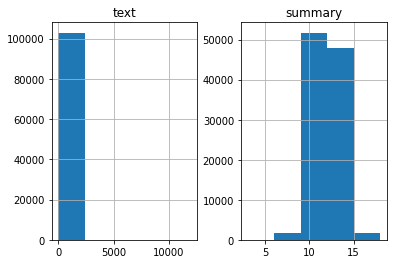

In [ ]:
# Max Sequence Lengths

p["text_clean"] = pd.Series(text)
p["summary_clean"] = pd.Series(summary)

text_count = []
summary_count = []

for sent in p['text_clean']:
    text_count.append(len(sent.split()))
    
for sent in p['summary_clean']:
    summary_count.append(len(sent.split()))

graph_df = pd.DataFrame() 

graph_df['text'] = text_count
graph_df['summary'] = summary_count

graph_df.hist(bins = 5)
plt.show()

In [ ]:
# texts that have 0-300 words
count = 0
for i in p["text_clean"]:
  if len(i.split()) <= 300:
    count = count + 1
print(count / len(p['text_clean']))

0.9740076762376718


In [ ]:
# 0-90 words for summary and 0-600 word for text

text_length_max = 300
summary_length_max = 50



In [ ]:
# Showing texts and summaries that falls below the max length of text and summaries

text_clean = np.array(p["text_clean"])
summary_clean = np.array(p["summary_clean"])

short_text = []
short_summary = []

for i in range(len(text_clean)):
    if len(summary_clean[i].split()) <= summary_length_max and len(text_clean[i].split()) <= text_length_max:
        short_text.append(text_clean[i])
        short_summary.append(summary_clean[i])
# Making a new DataFrame with two new column         
post_processing = pd.DataFrame({'text': short_text,'summary': short_summary})
# Text and summaries falling below max length
post_processing.head(3)

,text,summary
0,saurav kant an alumnus of upgrad and iiit-b pg...,_START_ upgrad learner switches to career in m...
1,kunal shah credit card bill payment platform c...,_START_ delhi techie wins free food from swigg...
2,new zealand defeated india by wickets in the f...,_START_ new zealand end rohit sharma-led india...


In [ ]:
# Tokenizer on training data
# Considering all the words that are rare, occuring less than five times
x_tokenizer = Tokenizer() 
x_tokenizer.fit_on_texts(list(x_tr))

thresh = 5

count = 0
total_count = 0

for key, value in x_tokenizer.word_counts.items():
    total_count = total_count + 1
    if value < thresh:
        count = count + 1
    
print("% of rare words in vocabulary: ",(count / total_count) * 100)

% of rare words in vocabulary:  62.75808286777208


In [ ]:
# This time not considering the rare words

x_tokenizer = Tokenizer(num_words = total_count - count) 
x_tokenizer.fit_on_texts(list(x_tr))

# Convert text sequences to integer sequences 
x_tr_seq = x_tokenizer.texts_to_sequences(x_tr) 
x_val_seq = x_tokenizer.texts_to_sequences(x_val)

# Pad zero upto maximum length
x_tr = pad_sequences(x_tr_seq,  maxlen=text_length_max, padding='post')
x_val = pad_sequences(x_val_seq, maxlen=text_length_max, padding='post')

# Size of vocabulary (+1 for padding token)
x_voc = x_tokenizer.num_words + 1

print("Size of vocabulary in X = {}".format(x_voc))

Size of vocabulary in X = 29132


In [ ]:
# Prepare a tokenizer on testing data
y_tokenizer = Tokenizer()   
y_tokenizer.fit_on_texts(list(y_tr))

thresh = 5

count = 0
total_count = 0

for key, value in y_tokenizer.word_counts.items():
    total_count = total_count + 1
    if value < thresh:
        count = count + 1
    
print("% of rare words in vocabulary:",(count / total_count) * 100)

% of rare words in vocabulary: 63.09808070122413


In [ ]:
# Not considering the rare ones
y_tokenizer = Tokenizer(num_words=total_count-count) 
y_tokenizer.fit_on_texts(list(y_tr))

# Text sequences to integer sequences 
y_tr_seq = y_tokenizer.texts_to_sequences(y_tr) 
y_val_seq = y_tokenizer.texts_to_sequences(y_val) 

# Pad zero upto maximum length
y_tr = pad_sequences(y_tr_seq, maxlen=summary_length_max, padding='post')
y_val = pad_sequences(y_val_seq, maxlen=summary_length_max, padding='post')

# Size of vocabulary with +1 considering padding token
y_voc = y_tokenizer.num_words + 1

print("Size of vocabulary in Y = {}".format(y_voc))

Size of vocabulary in Y = 12210


In [ ]:
print(x_tr[1])

[ 160   81 5773   87 1725 2262 1421 4037 2111  246   32    8  367   37
  325  337  124 3790    3  155  207    8  286    1  758  194 4725  246
    6  526    1  810  758  194 4725  246    6  526   11 1421  257 3115
    1 1018    4   16  377    3  646   83   29   85    4 1421  690  608
    3  373  137  194 4725  526  690    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0 

In [ ]:
# Validation set, removing empty summaries

index = []
for i in range(len(y_val)):
    count = 0
    for j in y_val[i]:
        if j != 0:
            count = count + 1
    if count == 2:
        index.append(i)

y_val = np.delete(y_val, index, axis=0)
x_val = np.delete(x_val, index, axis=0)